# Sucrose-Inversion Kinetics (CEU) Lab for CBE 154
Presented by Group MW1: Rahil Shaik, Sneha Kancharla, Alex Quemuel, Ethan Mibu

### Glucose Standard Results

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [21]:
df_stand = pd.read_csv("glucose-standard-res.csv")
df_stand

,Concentration of Reagent (g/L),Absorbance
0,0.02,0.52182
1,0.04,0.85720
2,0.06,1.03990
3,0.08,1.24860


##### our cuvette has a path length of 1 cm, so let's convert our concentration to units of cm^3

In [22]:
df_stand["Concentration (g/cm^3)"] = df_stand["Concentration of Reagent (g/L)"] * (1/1000)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3)
0,0.02,0.52182,0.00002
1,0.04,0.85720,0.00004
2,0.06,1.03990,0.00006
3,0.08,1.24860,0.00008


##### Now adjusting the absoprtion with the DI water baseline
##### $$ A_{\text{glucose,adj}} = A_{\text{glucose}} - A_{\text{DIW}}$$

In [23]:
A_DI1 = 0.1256 # DI Water Baseline Absorbance Day 1
A_DI2 = 0.13629 # DI Water Baseline Absorbance Day 2

df_stand["Absorbance adjusted"] = df_stand["Absorbance"].apply(lambda x: x - A_DI1)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted
0,0.02,0.52182,0.00002,0.39622
1,0.04,0.85720,0.00004,0.73160
2,0.06,1.03990,0.00006,0.91430
3,0.08,1.24860,0.00008,1.12300


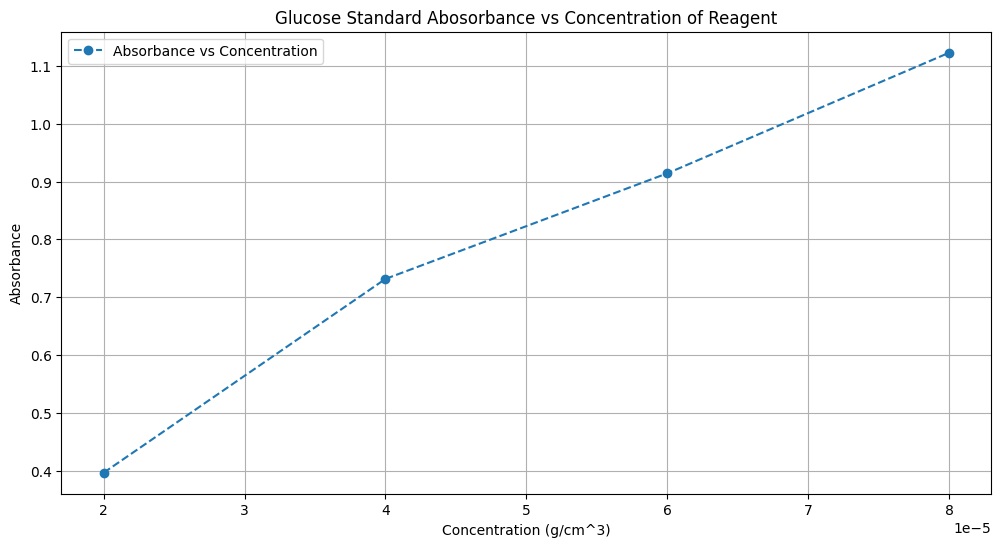

In [24]:
plt.figure(figsize=(12,6))
plt.plot(df_stand["Concentration (g/cm^3)"], df_stand["Absorbance adjusted"], label = "Absorbance vs Concentration",  marker= "o", linestyle="--")
plt.xlabel("Concentration (g/cm^3)")
plt.ylabel("Absorbance")
plt.title("Glucose Standard Abosorbance vs Concentration of Reagent")
plt.grid()
plt.legend()

plt.show()

### CEU Glucose Product Results

Note that all temperature recordings are in Celisus

In [25]:
df_res = pd.read_csv("CEU-glucose-results.csv")
df_res.query("Temperature == 50")

,Day,Type,Temperature,Absorbance,Sample
0,1,1,50,1.4619,1
1,1,1,50,1.5242,2
2,1,1,50,1.5791,3
9,2,2,50,1.6128,1
10,2,2,50,1.6304,2
11,2,2,50,1.6542,3


In [46]:
def adjust_absorbance(day, absorbance, A_DI1, A_DI2):
    if day == 1:
        return absorbance - A_DI1
    elif day == 2:
        return absorbance - A_DI2
    else:
        raise ValueError("Invalid day value")
    
df_res["Absorbance adjusted"] = df_res.apply(lambda x: adjust_absorbance(x["Day"], x["Absorbance"], A_DI1, A_DI2), axis=1)

df_res

,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,1,1,50,1.46190,1,1.33630
1,1,1,50,1.52420,2,1.39860
2,1,1,50,1.57910,3,1.45350
3,1,1,60,0.90298,1,0.77738
4,1,1,60,1.89460,2,1.76900
5,1,1,60,1.73960,3,1.61400
6,1,1,70,1.71290,1,1.58730
7,1,1,70,1.84670,2,1.72110
8,1,1,70,1.83360,3,1.70800
9,2,2,50,1.61280,1,1.47651


In [ ]:
# df_grouped = df_res.groupby(["Day", "Type", "Temperature"])["Absorbance adjusted"].mean().reset_index()
# df_grouped.rename(columns={"Absorbance adjusted": "Absorbance adjusted meaned"}, inplace=True)
# df_grouped

In [56]:
df_recent = df_res.query("Sample == 3").reset_index()
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,2,1,1,50,1.5791,3,1.45350
1,5,1,1,60,1.7396,3,1.61400
2,8,1,1,70,1.8336,3,1.70800
3,11,2,2,50,1.6542,3,1.51791
4,14,2,2,60,1.6690,3,1.53271
5,17,2,2,70,1.7100,3,1.57371


##### Now let's use Beer-Lambert law to determine glucose concentration from the absorbance, the first step is to find the absorptivity of the glucose reagent
##### $$A = \epsilon \cdot c \cdot l$$



In [57]:
df_stand["Molar absorptivity"] = df_stand["Absorbance adjusted"] / df_stand["Concentration (g/cm^3)"] 
avg_molar_absorptivity = df_stand["Molar absorptivity"].mean()
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted,Molar absorptivity
0,0.02,0.52182,0.00002,0.39622,19811.000000
1,0.04,0.85720,0.00004,0.73160,18290.000000
2,0.06,1.03990,0.00006,0.91430,15238.333333
3,0.08,1.24860,0.00008,1.12300,14037.500000


##### Beer-lambert law with 1 cm path length given by cuvette

In [58]:
path_length = 1 # cm
df_recent["Glucose concentration (mol/L)"] = df_recent["Absorbance adjusted"] / (avg_molar_absorptivity * path_length)

In [59]:
df_recent.query("Type == 2")["Glucose concentration (mol/L)"]

3    0.000090
4    0.000091
5    0.000093
Name: Glucose concentration (mol/L), dtype: float64

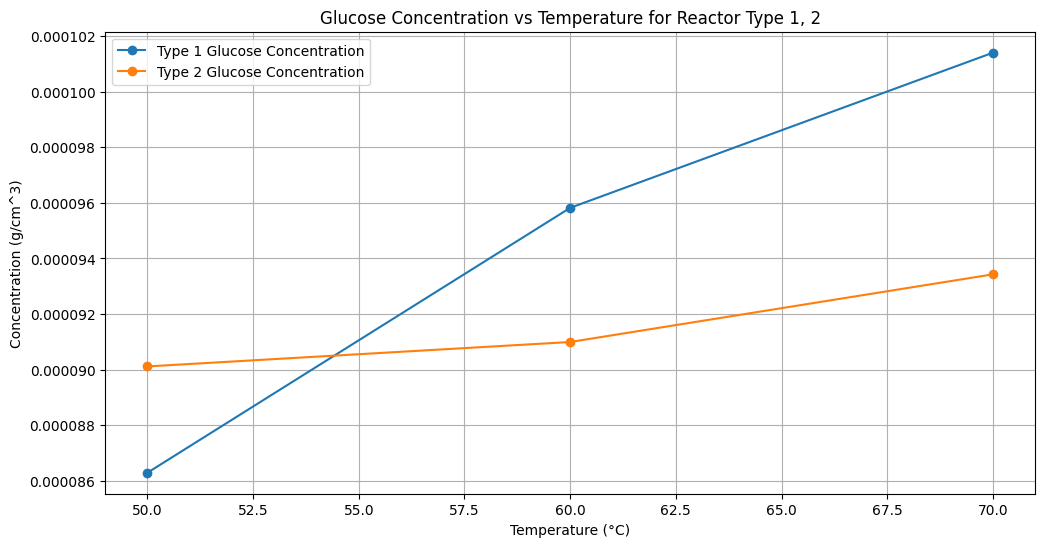

In [61]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Glucose concentration (mol/L)"], label = "Type 1 Glucose Concentration", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Glucose concentration (mol/L)"], label = "Type 2 Glucose Concentration", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Concentration (g/cm^3)")
plt.title("Glucose Concentration vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

##### Now using our surcose feed concentration, we can determine steady state conversion:
##### $$C_{\text{glucose}} = C_{\text{sucrose},0} \cdot X$$
##### $$X = \frac{C_{\text{glucose}}}{C_{\text{sucrose},i}}$$


In [62]:
C_sucrose_i = 7.6 * (1/1000) # g/cm^3
df_recent["Conversion"] = df_recent["Glucose concentration (mol/L)"] / C_sucrose_i

In [63]:
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (mol/L),Conversion
0,2,1,1,50,1.5791,3,1.45350,0.000086,0.011354
1,5,1,1,60,1.7396,3,1.61400,0.000096,0.012608
2,8,1,1,70,1.8336,3,1.70800,0.000101,0.013342
3,11,2,2,50,1.6542,3,1.51791,0.000090,0.011857
4,14,2,2,60,1.6690,3,1.53271,0.000091,0.011973
5,17,2,2,70,1.7100,3,1.57371,0.000093,0.012293


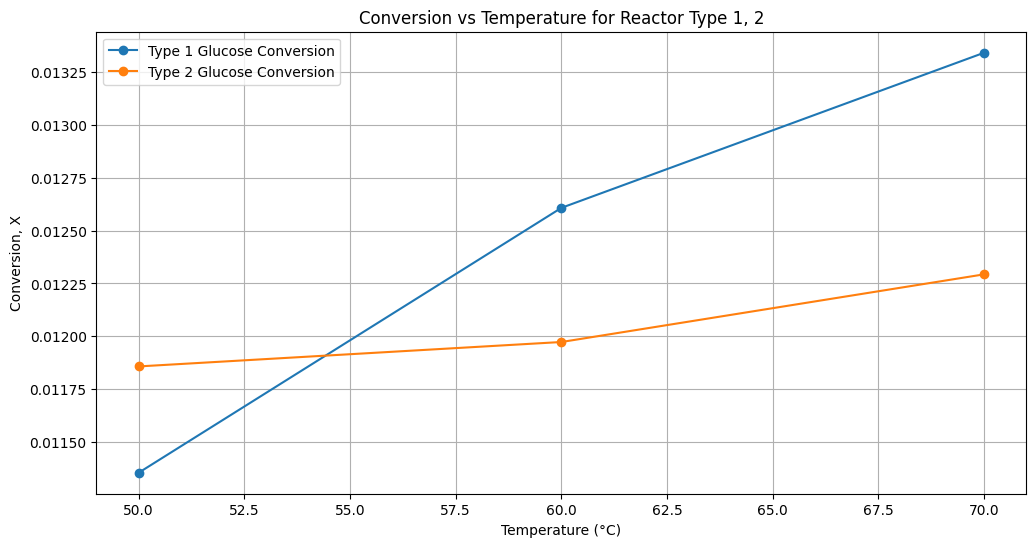

In [64]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Conversion"], label = "Type 1 Glucose Conversion", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Conversion"], label = "Type 2 Glucose Conversion", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Conversion, X")
plt.title("Conversion vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

### Solving for rate constant, k and diffusion coefficient, D

##### Our goal here is to use the relationship between thiele modulus, effectiveness to solve for k and D 

In [73]:
r1 =  (0.52 * .001) / 2 # Particle radius for smaller diameter resin (meters)
r2 = (1.1 * .001) / 2 # Particle radius for larger diameter resin (meters)
epsilon1 = 0.40  # Void fraction for smaller
epsilon2 = 0.38  # Void fraction for larger
tau = 10  # Arbitrary
L = 0.25 * .001 # cm
velocity = 1 # cm/s

In [74]:
def rate_constant_model(k, epsilon, L, velocity, X):
    ln1_minus_X = -(k * (1 - epsilon) * L) / velocity
    return np.exp(ln1_minus_X)  # Predict (1 - X)

def objective_k(params, df_grouped, epsilon, L, velocity):
    k = params[0]
    X_obs = df_grouped["Conversion"].values
    X_pred = 1 - rate_constant_model(k, epsilon, L, velocity, X_obs)
    # Sum of squared errors
    error = np.sum((X_obs - X_pred) ** 2)
    return error

initial_guess_k = [1e-3]

result_k = minimize(
    objective_k,
    initial_guess_k,
    args=(df_recent, epsilon1, L, velocity),
    method="Nelder-Mead"
)

k_opt = result_k.x[0]
print(f"Optimized rate constant type I (k): {k_opt:.5e} 1/s")

Optimized rate constant type I (k): 1.05000e-03 1/s


In [75]:
def thiele_modulus(k, De, R):
    return R * np.sqrt(k / De)

def effectiveness_factor(phi):
    if phi < 1e-6:
        return 1.0
    return (3 / phi) * (np.cosh(phi) - 1 / phi)

def objective_De(params, df_grouped, R, k):
    De = params[0]
    X_obs = df_grouped["Conversion"].values
    phi = thiele_modulus(k, De, R)
    eta = effectiveness_factor(phi)
    ln1_minus_X = -eta * k * (1 - epsilon1) * L / velocity
    X_pred = 1 - np.exp(ln1_minus_X)
    error = np.sum((X_obs - X_pred) ** 2)
    return error

initial_guess_De = [1e-9]

result_De = minimize(
    objective_De,
    initial_guess_De,
    args=(df_recent, r1, k_opt),
    method="Nelder-Mead"
)

De_opt = result_De.x[0]
print(f"Optimized diffusion coefficient type I (De): {De_opt:.5e} m^2/s")


Optimized diffusion coefficient type I (De): 1.00000e-09 m^2/s
